In [1]:

# import mlflow

import os
import sys
import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString,Point
import numpy as np
import matplotlib.pyplot as plt
# import bokeh as bh

from datetime import datetime
import taxi_driver.taxi_driver as td


import sklearn.metrics as skm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score

# mlflow.sklearn.autolog()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error


from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

%load_ext autoreload
%autoreload 2

## Init Read and cleaning

In [6]:
#setting some much needed paths 

dataPath = os.path.join("data")
csvPath  = os.path.join(dataPath,"CSV")
shpPath  = os.path.join(dataPath,"SHP")

outputPath = os.path.join("outputs")
imagePath = os.path.join(outputPath,"images")



In [7]:
zoneShpPath = os.path.join(shpPath,"taxi_zones.shp")

#combine in one
# march_path = os.path.join(csvPath,"march_data.csv")
# june_path = os.path.join(csvPath,"june_data.csv")
# nov_path = os.path.join(csvPath,"november_data.csv")

# taxi_df=td.Taxidf([march_path,june_path,nov_path],sample_fraction=0.2,taxi_zones_shp_path=zoneShpPath)
#taxi_df.convert_dates()

#save the combined sample df
# csv_sample_path = os.path.join(csvPath,"sample_csv.csv")
# taxi_df.taxi_data.to_csv(csv_sample_path)
#---------------------------------------------------

#load the sample
csv_sample_path = os.path.join(dataPath,"yellow_tripdata_2025-01.parquet")
taxi_df=td.Taxidf(csv_sample_path,taxi_zones_shp_path=zoneShpPath)
taxi_df.convert_dates()

/media/itoumpalidis/SlowHDD/linux_part/t2l/nyc_taxi_tips/taxi_driver/taxi_driver.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.taxi_data=pd.concat([self.taxi_data,temp_df])


Sampling the main dataset by selecting only the trips payed with card, tip amount, trip distance and fare amount
that are non negative.

## Data Processing / Feature Engineering

In [8]:
clean_df=taxi_df.taxi_data.copy()

In [53]:
import holidays
us_holidays = holidays.UnitedStates()
grouped_date=taxi_df.grouped_date()
holidays=[datetime.strptime(i,"%Y-%m-%d") in grouped_date for i in list (grouped_date.index)] 

if(not True in holidays):
    print("there are no holidays in the data set")
else:
    print("check for the holidays")

there are no holidays in the data set


Introduce some new features that might help on the modelling

In [9]:
clean_df['is_weekend'] = clean_df['pu_day'].isin([5, 6]).astype(int)
clean_df['is_night'] = clean_df['pu_hour'].apply(lambda h: 1 if h < 6 or h > 21 else 0)


clean_df['dollar_per_mile']=clean_df['fare_amount']/clean_df['trip_distance']
clean_df['tip_to_fare']=clean_df['tip_amount']/clean_df['fare_amount']
clean_df['duration_s']=(clean_df['tpep_dropoff_datetime']-clean_df['tpep_pickup_datetime']).apply(lambda x:x.seconds)
clean_df['speed_kpi']=clean_df['trip_distance']/clean_df['duration_s']

mod_tip = clean_df['tip_amount']%1
clean_df['set_tip_amount_flag']=mod_tip.apply(lambda x:0 if x==0 else 1)

clean_df['Airport_flag']=clean_df['Airport_fee'].apply(lambda x: 0 if x==0 else 1)
clean_df['congestion_surcharge_flag']=clean_df['congestion_surcharge'].apply(lambda x: 0 if x==0 else 1)
clean_df['mta_tax_flag']=clean_df['mta_tax'].apply(lambda x: 0 if x==0 else 1)

filter out outliers 

In [10]:
#select for now only one vendor id
clean_df = clean_df[clean_df['VendorID']==2]


#will keep only the payment checks
clean_df = clean_df[clean_df['payment_type']==1]

# I will create a sample of only the non_negative
clean_df= clean_df[clean_df['tip_amount']>0]
clean_df= clean_df[clean_df['trip_distance']>0]

# duration >0
clean_df = clean_df[clean_df['duration_s']>0]


#controlling the value between >0 
clean_df=clean_df.loc[(clean_df['fare_amount']>0)]


# tip <100% of the price of the ride
clean_df=clean_df[clean_df['tip_to_fare']<1]

clean_df = clean_df.dropna()

In [10]:

# encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
# spatial_array = encoder.fit_transform(clean_df[['PULocationID','DOLocationID']])


In [11]:
# fileName = "clean_sample.csv"
# filePath = os.path.join(csvPath,fileName)
clean_df.to_csv('./data/clean_sample.csv',index=False)


## Spatial regression 

In [663]:
from sklearn.preprocessing import FunctionTransformer
from spreg import ML_Lag

taxi_df.compute_taxi_zones()

coordsDict = dict(zip(taxi_df.taxi_zones['PULocationID'],list(zip(long,lat))))

groupedDf = clean_df.groupby(['PULocationID','DOLocationID','set_tip_amount_flag','pickup_time','dropoff_time'])[['fare_amount','tip_amount']].mean().reset_index()
groupedDf['PUCoords']=groupedDf['PULocationID'].apply(lambda x:coordsDict[x] if x in coordsDict.keys() else None)
groupedDf[['PULong','PULat']]=pd.DataFrame(groupedDf['PUCoords'].tolist())
groupedDf=groupedDf.dropna()

groupedDf['DOCoords']=groupedDf['DOLocationID'].apply(lambda x:coordsDict[x] if x in coordsDict.keys() else None)
groupedDf[['DOLong','DOLat']]=pd.DataFrame(groupedDf['PUCoords'].tolist())
groupedDf=groupedDf.dropna()


coords = groupedDf[['PULong', 'PULat']].values
w = KNN.from_array(coords, k=5)

# Encode hour as Fourier series
groupedDf['pu_hour_sin'] = np.sin(2 * np.pi * groupedDf['pu_hour'] / 24)
groupedDf['pu_hour_cos'] = np.cos(2 * np.pi * groupedDf['pu_hour'] / 24)

y = groupedDf['set_tip_amount_flag']
X = groupedDf[['fare_amount','pu_hour_sin','pu_hour_cos']]

model = ML_Lag(y, X, w=w)

# View summary
print(model.summary)

## Classification problem structure

It might be possible to work on a pipeline of two models where the first one classifies if the trip would be more propable to have a set amount regardless the total fare amount and the ones that have a percentage 

In [604]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,f1_score

model = xgb.XGBClassifier()
model.fit(X[:-4637], y[:-4637])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [606]:

X_valid = X[-4637:]
y_valid = y[-4637:]
pred = model.predict(X_valid)

accuracy = f1_score(pred,y_valid)
print(accuracy)

0.6270767055496642


In [607]:
accuracy_score(pred,y_valid)

0.5449644166486953

## Temporal analysis of the tip amount

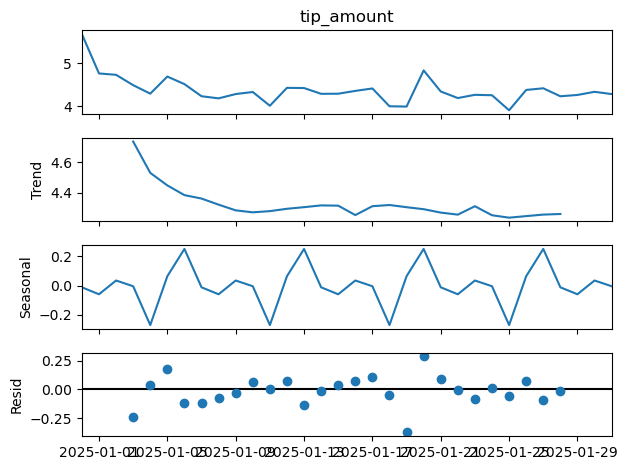

In [453]:
from statsmodels.tsa.seasonal import seasonal_decompose
daily_tips = clean_df.groupby(clean_df['tpep_pickup_datetime'].dt.date)['tip_amount'].mean()

result = seasonal_decompose(daily_tips, model='additive', period=7)
result.plot()
plt.show()

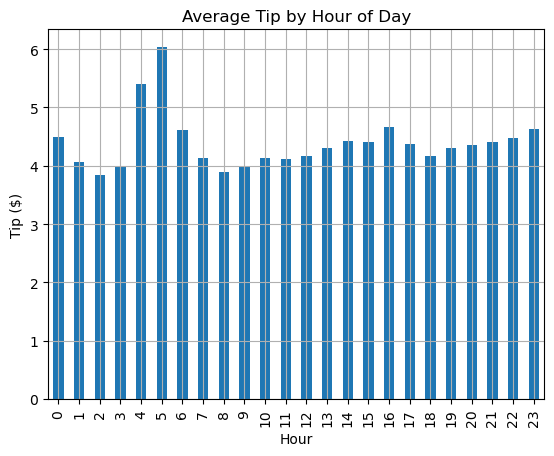

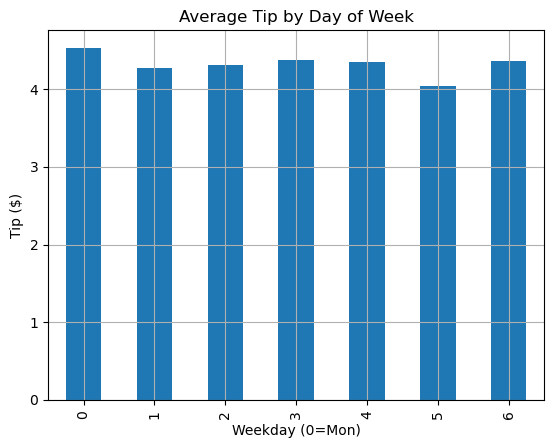

In [446]:
# Hour of Day
hourly_avg = clean_df.groupby('pu_hour')['tip_amount'].mean()
hourly_avg.plot(kind='bar', title='Average Tip by Hour of Day')
plt.ylabel('Tip ($)')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

# Day of Week
weekday_avg = clean_df.groupby('pu_day')['tip_amount'].mean()
weekday_avg.plot(kind='bar', title='Average Tip by Day of Week')
plt.ylabel('Tip ($)')
plt.xlabel('Weekday (0=Mon)')
plt.grid(True)
plt.show()

In [448]:
from scipy.stats import spearmanr

# Convert dates to ordinal (numeric time)
time_numeric = clean_df['tpep_pickup_datetime'].map(pd.Timestamp.toordinal)
corr, pval = spearmanr(time_numeric, clean_df['tip_amount'])

print(f"Spearman Correlation: {corr:.4f}, p-value: {pval:.4e}")

Spearman Correlation: -0.0029, p-value: 1.4924e-05


In [38]:
Q1 = clean_df['tip_to_fare'].quantile(0.25)
Q3 = clean_df['tip_to_fare'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Check how many values exceed the upper bound
print(f"Upper bound: {upper_bound}")
print((clean_df['tip_to_fare'] > upper_bound).mean())

# Filter based on IQR outlier threshold
clean_df = clean_df[clean_df['tip_to_fare'] <= upper_bound]

Upper bound: 0.4701778105539167
0.029458876636470604


## Establishing base lines

In [ ]:
clean_df=pd.read_csv('./data/clean_sample.csv')

In [12]:

corr = clean_df[["tip_to_fare","tip_amount",'passenger_count',"trip_distance","fare_amount","duration_s",'Airport_flag','congestion_surcharge_flag','mta_tax_flag']].corr()
corr.style.background_gradient(cmap='coolwarm')

,tip_to_fare,tip_amount,passenger_count,trip_distance,fare_amount,duration_s,Airport_flag,congestion_surcharge_flag,mta_tax_flag
tip_to_fare,1.000000,0.055972,-0.007824,-0.204626,-0.299501,-0.141636,-0.131250,0.113391,0.066121
tip_amount,0.055972,1.000000,0.045399,0.645638,0.864457,0.305812,0.595979,-0.294938,-0.284097
passenger_count,-0.007824,0.045399,1.000000,0.033759,0.051557,0.027377,0.016728,-0.010645,-0.043426
trip_distance,-0.204626,0.645638,0.033759,1.000000,0.736778,0.260143,0.545822,-0.270007,-0.152417
fare_amount,-0.299501,0.864457,0.051557,0.736778,1.000000,0.348904,0.645540,-0.372686,-0.349250
duration_s,-0.141636,0.305812,0.027377,0.260143,0.348904,1.000000,0.219882,-0.091542,-0.047427
Airport_flag,-0.131250,0.595979,0.016728,0.545822,0.645540,0.219882,1.000000,-0.427711,-0.074960
congestion_surcharge_flag,0.113391,-0.294938,-0.010645,-0.270007,-0.372686,-0.091542,-0.427711,1.000000,0.279849
mta_tax_flag,0.066121,-0.284097,-0.043426,-0.152417,-0.349250,-0.047427,-0.074960,0.279849,1.000000


My first intuition looking the highly correlated values of tip amount and fare_amount,trip_distance is to try to fit a linear model on the data and see how it behaves. So first we will create a simple linear regression model that will be our base model. Did a test with fare amount and trip duration but the coefficient for the trip duration was extremly low. 

In [13]:
#split the df two to parts 


X=clean_df[["fare_amount",'Airport_flag','trip_distance','congestion_surcharge_flag','mta_tax_flag']]
y=clean_df[["tip_amount"]]


In [15]:

# 🪓 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:

# 📊 Baseline 1: Dummy Mean Regressor
mean_model = DummyRegressor(strategy="mean")
mean_model.fit(X_train, y_train)
y_pred_mean = mean_model.predict(X_test)

# 📊 Baseline 2: Dummy Median Regressor
median_model = DummyRegressor(strategy="median")
median_model.fit(X_train, y_train)
y_pred_median = median_model.predict(X_test)

# 📈 Baseline 3: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

# 🌳 Baseline 4: Simple Decision Tree
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# 📋 Evaluation Function
def eval_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<20} | MSE: {mse:.4f} | R²: {r2:.4f}")

# 🧾 Report
print("Model Evaluation:")
eval_model("Dummy Mean", y_test, y_pred_mean)
eval_model("Dummy Median", y_test, y_pred_median)
eval_model("Linear Regression", y_test, y_pred_linreg)
eval_model("Decision Tree", y_test, y_pred_tree)

Model Evaluation:
Dummy Mean           | MSE: 13.8305 | R²: -0.0000
Dummy Median         | MSE: 14.9787 | R²: -0.0830
Linear Regression    | MSE: 3.3939 | R²: 0.7546
Decision Tree        | MSE: 3.6095 | R²: 0.7390


From our first experiment, we can observe that we can achieve good results in MSE and R² with LR and DT to achieve very similar results,which can be verified also with some additional cross validation.

In [87]:

coef =linreg.coef_[0]
for idx,name in enumerate(X_test.columns):
    
    print(f"{name:<20} | coef: {coef[idx]:.4f} ")

fare_amount          | coef: 0.1831 
Airport_flag         | coef: 1.1305 
trip_distance        | coef: 0.0032 
congestion_surcharge_flag | coef: 0.8810 
mta_tax_flag         | coef: -0.1171 


In [76]:
print(cross_val_score(linreg, X, y, scoring='r2', cv=5))
print(cross_val_score(tree, X, y, scoring='r2', cv=5))

[0.74481462 0.75933672 0.75041492 0.7562722  0.74517815]
[0.72881719 0.74205177 0.73221724 0.73916309 0.72812333]


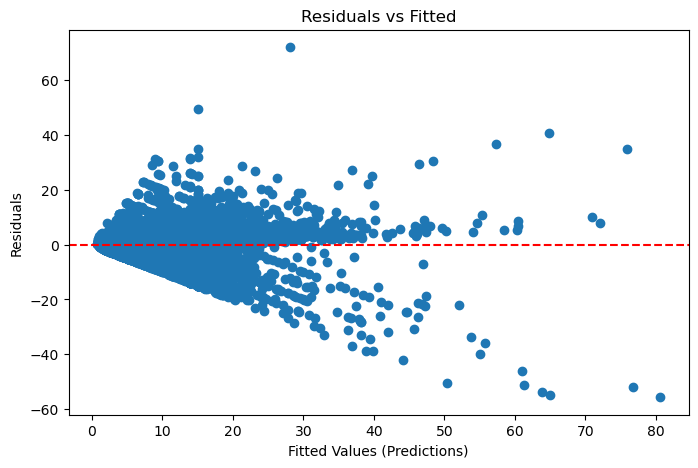

In [73]:


predicted_tip=linreg.predict(X_test)
residuals = y_test['tip_amount'] - predicted_tip.flatten()

plt.figure(figsize=(8, 5))
plt.scatter(predicted_tip, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

(array([7.00000e+00, 1.40000e+01, 7.90000e+01, 5.93400e+03, 3.50094e+05,
        8.60000e+02, 4.10000e+01, 4.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-55.64417599, -42.89186864, -30.13956129, -17.38725393,
         -4.63494658,   8.11736077,  20.86966813,  33.62197548,
         46.37428283,  59.12659018,  71.87889754]),
 <BarContainer object of 10 artists>)

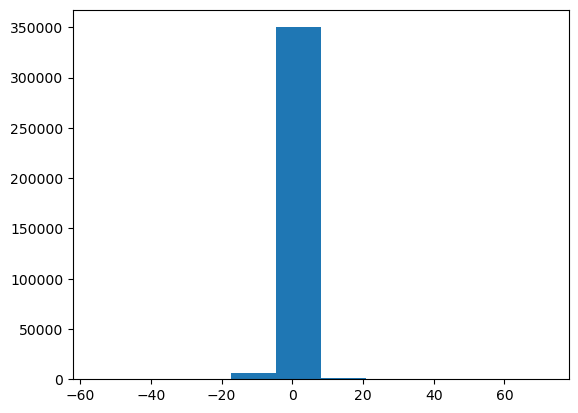

In [78]:
plt.hist(residuals)

Plotting the residuals over the fitted values we can obeserve that our model suffers from heteroscedacity

### Log Transform the target

In [74]:
# Log transform 
linregLog = LinearRegression()
linregLog.fit(X_train, np.log(y_train))
y_pred_linregLog = linregLog.predict(X_test)

eval_model("Linear Regression with Log transformation", np.log(y_test), y_pred_linregLog)


Linear Regression with Log transformation | MSE: 0.2512 | R²: 0.4718


### Weighted Least Squares

In [82]:
import statsmodels.api as sm

# Estimate variance from residuals of OLS
ols_resid = sm.OLS(y, X).fit().resid
weights = 1 / (ols_resid**2 + 1e-6)  # avoid division by zero

model_wls = sm.WLS(y, X, weights=weights).fit()
y_pred_wls = model_wls.predict(X_test)
eval_model("WLS ", y_test, y_pred_wls)


residuals = y_test['tip_amount'] - y_pred_wls.values.flatten()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_wls, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

## Regularisation

We can try apply regularisation on the regression model in case the hetersoscedacity is caused by multicollinearity of the predictors

### Elastic Net

In [79]:
from sklearn.linear_model import ElasticNetCV

# Automatically tune alpha and l1_ratio using cross-validation
elastic_net = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, 1], random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_elastic = elastic_net.predict(X_test)

# Evaluate
eval_model("Elastic Net", y_test, y_pred_elastic)

terms = [f"{coef:.4f}*{feature}" for feature, coef in zip(X_train.columns, elastic_net.coef_)]
equation = f"tip_amount = {elastic_net.intercept_:.4f} + " + " + ".join(terms)
print(equation)

/home/itoumpalidis/anaconda3/envs/algae/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Elastic Net          | MSE: 3.4589 | R²: 0.7499


### Sequential Feature Selector

In [88]:
from sklearn.feature_selection import SequentialFeatureSelector

base_model = LinearRegression()

# Forward stepwise selection
sfs = SequentialFeatureSelector(base_model, direction='forward', n_features_to_select='auto', cv=5)
sfs.fit(X_train, y_train)

# Reduced feature set
selected_features = X_train.columns[sfs.get_support()]
print("Selected features:", list(selected_features))

# Fit final model on selected features
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

stepwise_model = LinearRegression()
stepwise_model.fit(X_train_reduced, y_train)
y_pred_stepwise = stepwise_model.predict(X_test_reduced)

# Evaluate
eval_model("Stepwise Linear", y_test, y_pred_stepwise)
terms = [f'{feature}*{coef:.4f}' for feature, coef in zip(selected_features, stepwise_model.coef_[0])]
equation = f"tip_amount = {stepwise_model.intercept_[0]:.4f} + " + " + ".join(terms)
print(equation)

Selected features: ['fare_amount', 'Airport_flag']
Stepwise Linear      | MSE: 3.4245 | R²: 0.7524
tip_amount = 1.0337 + fare_amount*0.1824 + Airport_flag*0.9078


## RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='sqrt')
rf.fit(X_train, y_train)
y_pred_rfr = rf.predict(X_test)
eval_model('RFRegressor',y_pred_rfr,y_test)

test the inclusion of the spatial encoded vectors

In [16]:
indices = np.arange(len(clean_df))

# 🪓 Train/Test split
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]

y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

In [20]:
x_train = np.concatenate((X_train,spatial_array[train_idx]),axis=0)

rf.fit(x_train, y_train)

x_test = np.concatenate((X_test,spatial_array[test_idx]),axis=1)

y_pred_rfr = rf.predict(x_test)
eval_model('RFRegressor',y_pred_rfr,y_test)

RFRegressor          | MSE: 4.6930 | R²: 0.1888


## HistGradientBoostingRegressor

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor


In [3]:
clean_df=pd.read_csv('./data/clean_sample.csv')

In [5]:
numerical_cols=['fare_amount','trip_distance','duration_s']


categorical_cols = ['RatecodeID', 
                    'store_and_fwd_flag',
                    'PULocationID', 
                    'DOLocationID',
                    'pu_day',
                    'pu_hour',
                    'Airport_flag',
                    'congestion_surcharge_flag',
                    'is_weekend',
                    'is_night',
                    'mta_tax_flag'
]

In [6]:
# No imputer here
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pass-through numerical features as-is (no imputation)
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

In [7]:
X=clean_df[numerical_cols+categorical_cols]
y=clean_df['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
pipe_hist = Pipeline([
    ('preprocess', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])


In [16]:

pipe_hist.fit(X_train, np.log(y_train))
y_pred_hist = pipe_hist.predict(X_test)

In [17]:
# Evaluation metrics
mae = mean_absolute_error(np.log(y_test), y_pred_hist)
mse = mean_squared_error(np.log(y_test), y_pred_hist)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(y_test), y_pred_hist)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


MAE: 0.297
MSE: 0.217
RMSE: 0.466
R²: 0.544


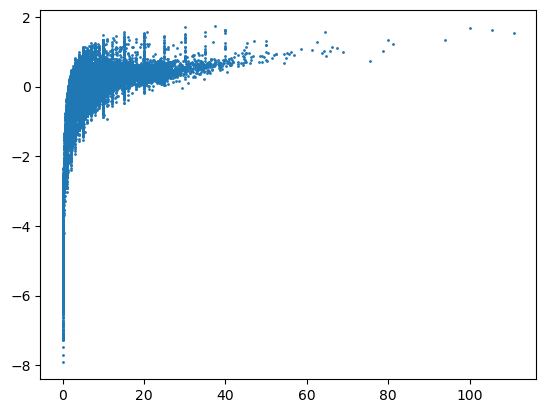

In [19]:
plt.scatter(y_test, np.log(y_test)-y_pred_hist,s=1)

In [22]:
import shap


# 2. Extract the trained preprocessor and regressor
preprocessor = pipe_hist.named_steps['preprocess']
regressor = pipe_hist.named_steps['model']

# 3. Transform the input features for SHAP
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# 4. Use SHAP TreeExplainer on the final estimator
import shap
explainer = shap.Explainer(regressor, X_train_transformed[0:100])


In [25]:
shap_values = explainer(X_test_transformed,check_additivity=False)


100%|===================| 356805/357035 [09:10<00:00]        

In [30]:
ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)

feature_names = list(encoded_cat_cols) + numerical_cols


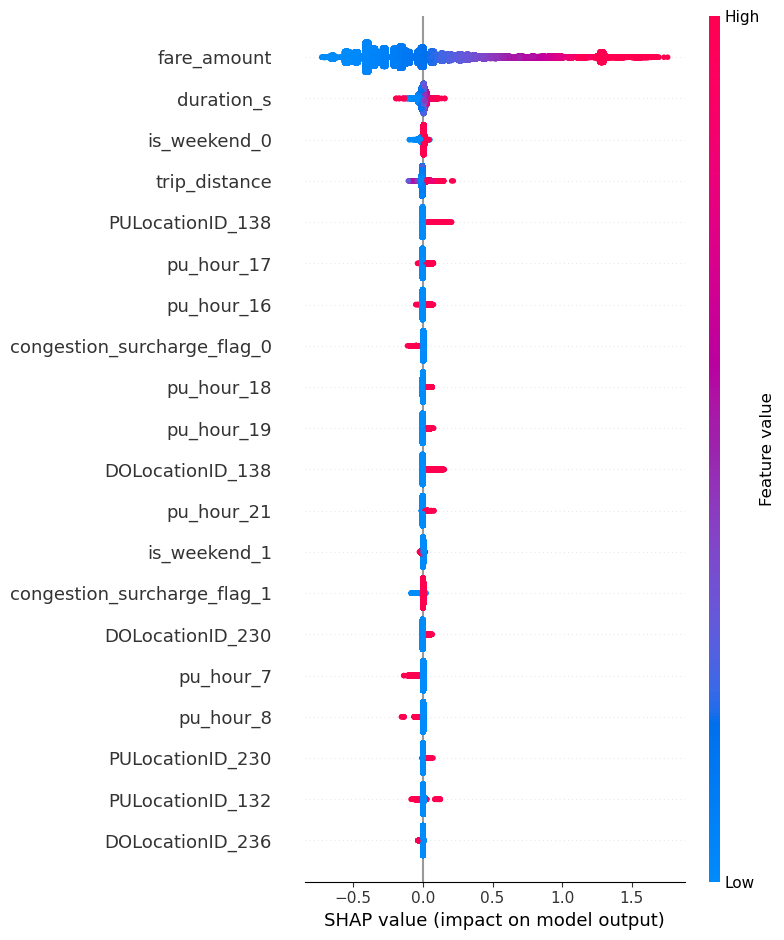

In [29]:

# 5. Visualize
shap.summary_plot(shap_values, X_test_transformed,feature_names=feature_names)

## XGBOOST

In [32]:
from xgboost import XGBRegressor

pipe_xgb = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        tree_method='hist'
    ))
])

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)

In [33]:
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


MAE: 0.998
MSE: 3.233
RMSE: 1.798
R²: 0.766


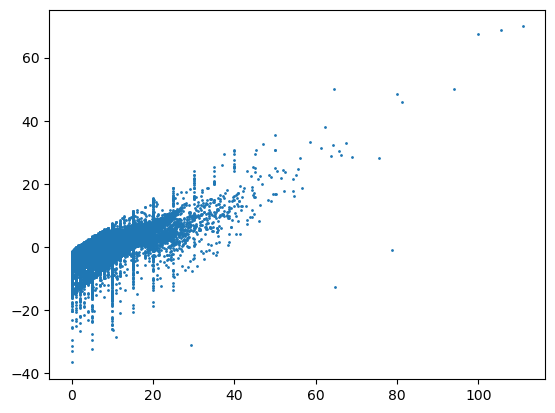

In [34]:
plt.scatter(y_test, y_test-y_pred_xgb,s=1)

## CatBoost

In [2]:
from catboost import CatBoostClassifier
clean_df=pd.read_csv('./data/clean_sample.csv')

In [3]:
# Power Transformer 
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

In [4]:

# Intlize Power Transformer
pt = PowerTransformer(standardize=True, method='yeo-johnson')

# Numerical Columsn to Transform
cols_num_pt = ['tolls_amount', 'extra']

# Fit and Transform
for col in cols_num_pt:
    # Fit and transform
    clean_df[col] = pt.fit_transform(clean_df[[col]])

# Intlize Power Transformer
qt = QuantileTransformer(output_distribution='normal')

# Numerical Columsn to Transform 
cols_num = ['trip_distance', 'fare_amount','total_amount']

# Fit and Transform
for col in cols_num:
    # Fit and transform
    clean_df[col] = qt.fit_transform(clean_df[[col]])
    

In [15]:
import seaborn as sns
# Paellete
palette = ['#8DECB4', '#41B06E', '#FFF5E0']

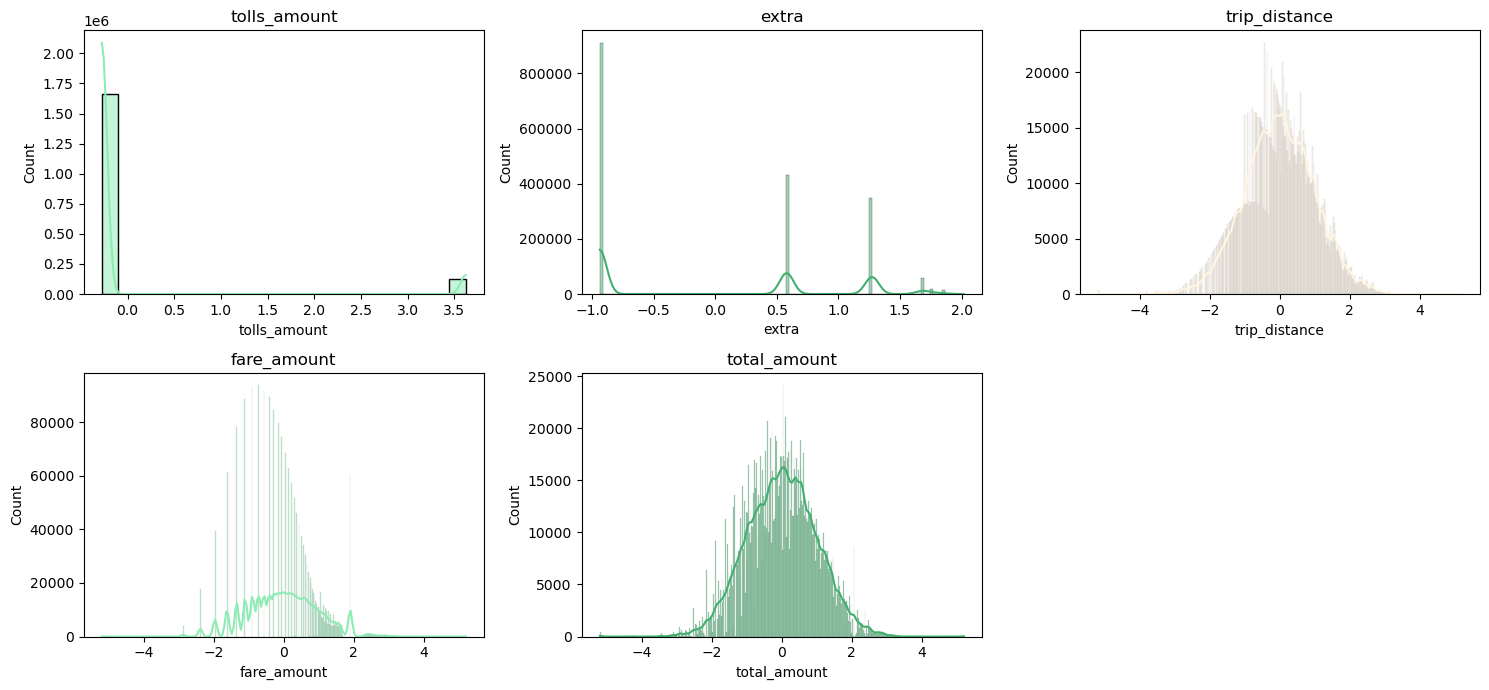

In [45]:
# Numerical columns to plot
cols_num = ['tolls_amount', 'extra', 'trip_distance', 'fare_amount', 'total_amount']

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each numerical column
for i, col in enumerate(cols_num):
    ax = axes[i]
    sns.histplot(clean_df[col], ax=ax, kde=True, color=palette[i % len(palette)])
    ax.set_title(col)  # Set title for each subplot

# Remove any remaining empty subplots
for i in range(len(cols_num), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

In [5]:
numerical_cols=['fare_amount','trip_distance','total_amount','extra','tolls_amount']


categorical_cols = ['pu_day',
                    'pu_hour',
                    'Airport_flag',
                    'congestion_surcharge_flag',
                    'is_weekend',
                    'is_night',
                    'mta_tax_flag'
]

In [6]:

X=clean_df[numerical_cols+categorical_cols]
y=clean_df['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# # # =================================================================================================================
# # #                        Params < CAT Classifier
# # #================================================================================================================== 

# # # =================================================================================================================
# # #                        Train < CAT Classifier
# # #================================================================================================================== 
C_BASE = CatBoostClassifier(**cat_params)
C_CV = cross_val_score(C_BASE,
                       X, 
                       y, 
                       scoring='roc_auc',
                       cv=5, 
                       n_jobs=-1)
# # # =================================================================================================================
# # #                        ROC AUC < CAT Classifier
# # #================================================================================================================== 
print_heading(f"The Average ROC AUC Of CatBoost Classifier is: {C_CV.mean()}")

In [7]:
X_train.shape

(1428139, 12)

In [ ]:
# cat_params = {
#     'n_estimators': 100,
#     'learning_rate': 0.10899577626375372,
#     'depth': 7,
#     'colsample_bylevel': 0.7340962061535496,
#     'random_strength': 6.262882561405091,
#     'min_data_in_leaf': 92,
#     'verbose': 0
# } 

cat_params = {
    'iterations': 300,
    'learning_rate': 0.1,
    'depth': 4,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'verbose': 50,
    'early_stopping_rounds': 30,
    'random_seed': 42,
    'task_type': 'CPU',
    'one_hot_max_size': 2,
}

# No imputer here
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pass-through numerical features as-is (no imputation)
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

catBoost = Pipeline([
    ('preprocess', preprocessor),
    ('model', CatBoostClassifier(**cat_params))
])

catBoost.fit(X_train, y_train)
y_pred_xgb = catBoost.predict(X_test)